In [13]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

This notebook is a simple implementation of the REINFORCE algorithm. REINFORCE is a basic policy gradient algorithm which is on-policy. For such a policy gradient algorithm, the objective function is the average one-step reward:

\begin{equation}
\begin{aligned}
J\doteq\bar{r}_\pi & \doteq d_\pi^T r_\pi \\
& =\sum_s d_\pi(s) r_\pi(s) \\
& =\mathbb{E}\left[r_\pi(S)\right]
\end{aligned}
\end{equation}

Our goal is to solve an optimization problem to maximize the objective function $J$ and obtain the optimal policy $\pi^*$. Here, the policy will be a parameterized function $\pi(a \mid s, \theta)$, where $\theta$ is the parameter of the policy function. The gradient of the objective function can be **approximated** as:

\begin{equation}
\nabla_\theta J \approx \mathbb{E}\left[\nabla_\theta \ln \pi(A \mid S, \theta) q_\pi(S, A)\right]
\end{equation}
As the discount $\gamma$ approaches 1, the approximation becomes more accurate. When $\gamma=1$, both sides of the equation are equal.

One can use the sothastic gradient ascent to update the policy parameter $\theta$:

\begin{equation}
\theta_{t+1}=\theta_t+\alpha \nabla_\theta \ln \pi\left(a_t \mid s_t, \theta_t\right) q_t\left(s_t, a_t\right)
\end{equation}

The above procedure constructs the *"main loop"* of classical policy gradient algorithms. From the structure of the equation, we can treat the term $\ln \pi\left(a_t \mid s_t, \theta_t\right) q_t\left(s_t, a_t\right)$ as the **approximated** objective function of the optimization problem. Such objective function is actually the *loss function* for training the policy network. Therefore, the policy network can be trained by **maximize** the loss function:

\begin{equation}
"loss" = \ln \pi\left(a_t \mid s_t, \theta_t\right) q_t\left(s_t, a_t\right)
\end{equation}

Again, we should remember the "policy training" is actually solving an optimization problem but not to approximate something. Hence, we use "loss" in the above equation. Interestingly, we can use any nonlinear solver to solve the problem such as *IPOPT*, *SNOPT* and even *heuristics* such as genetic algorithm. However, the most common method in RL is to use the gradient descent method. In this notebook, we will continue to use feature of automatic differentiation in PyTorch to calculate the gradient of the loss function and update the policy network.

Now the question is how to calculate the current action value $q_t(s_t,a_t)$. Similar to the MC Algorithm, REINFORCE uses the Monte Carlo method to estimate the action value since $q_t(s_t,a_t) = \mathbb{E} \left[G_t \mid S_t=s_t, A_t=a_t\right]$. Therefore, the learning progress (i.e., parameters updating) only comes after the end of an episode and lead to a off-line learning.


In [14]:
class REINFORCE_Agent():
    """ Since the discrete actions have been redefined as {0,1,2,3} by using the wapper file, we can simply represent the action by a number. """
    
    def __init__(self,
                 policy_network:torch.nn, # The policy network
                 episode_recorder:object, # The episode recorder
                 optimizer:torch.optim, 
                 gamma:float = 0.9,
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        
        self.device = device
        self.policy_network = policy_network
        self.episode_recorder = episode_recorder
        self.optimizer = optimizer
        
        self.gamma = gamma
            
    def get_action(self, obs:np.ndarray) -> int:
        """ The output of policy network is the action distribution. 
            Apart from the sampled action, the sampled action distribution is used for training the policy network."""
        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        picked_action = torch.distributions.Categorical(self.policy_network(obs)).sample()  
        picked_action_prob = self.policy_network(obs).gather(0, picked_action)
        log_prob = torch.log(picked_action_prob)
               
        return picked_action.item(), log_prob
    
    def calculate_discounted_return(self, episode_reward:torch.tensor) -> torch.tensor:
        """G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{T-t-1} R_{T} """
        
        length = len(episode_reward)
        G = torch.zeros_like(episode_reward)
        for i in range(length):
            G[i] = sum([episode_reward[j] * self.gamma ** j for j in range(i, length)])

        return G
    
    def episode_train(self, trajectory:list) -> None:
        """ Train the policy network with the trajectory of one episode. """
        self.trajctrory = trajectory
        trajectory_length = len(trajectory) # Get the length of the trajectory
        episode_reward = torch.tensor([trajectory[i][0] for i in range(trajectory_length)], dtype = torch.float32).to(self.device)
        G = self.calculate_discounted_return(episode_reward)
        episode_log_prob = [trajectory[i][1] for i in range(trajectory_length)]
        """ Here, we should reset the gradient of the optimizer for each episode BUT NOT for each step, calculate the gradient for each step, and then call the optimizer for a update.
            Because the parameters of the policy network should be updated considering the whole trajectory. """
        self.optimizer.zero_grad()
        for step in range(trajectory_length):
            loss = -episode_log_prob[step] * G[step]
            loss.backward()
        self.optimizer.step()          

In [15]:
class Policy_Network(torch.nn.Module):
    
    def __init__(self,obs_dim:int,action_dim:int) -> None:
        super(Policy_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,128)
        self.fc2 = torch.nn.Linear(128,action_dim)
                    
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x),dim=0) # The softmax function is used to convert the output to a probability distribution
        return x

In [16]:
class Episode_Recorder():
    """ Record the trajectory, i.e, Tuple(r,log_pi), of one episode. 
        pi(a|s) is the probability of taking action a in state s.)"""
    
    def __init__(self, device:torch.device = torch.device("cpu")) -> None:
        self.trajectory = []
        self.device = device
        
    def append(self, reward:float, log_prob:torch.tensor) -> None:
        self.trajectory.append([reward, log_prob])
        
    def get_trajectory(self) -> list:
        return self.trajectory
    
    def clear(self) -> None:
        self.trajectory = []

In [17]:
class TrainManager():
    
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 lr:float = 0.001,
                 gamma:float = 0.9
                 ) -> None:
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space) 
        action_dim = env.action_space.n
        episode_recorder = Episode_Recorder(device = self.device)
        policy_network = Policy_Network(obs_dim,action_dim).to(self.device)
        optimizer = torch.optim.Adam(policy_network.parameters(),lr=lr)
        self.agent = REINFORCE_Agent(policy_network = policy_network,
                               episode_recorder = episode_recorder,
                               optimizer = optimizer,
                               gamma = gamma,
                               device = self.device)
        
        self.episode_total_rewards = np.zeros(self.episode_num)
        self.index_episode = 0    
        
    def train_episode(self,is_render:bool=False) -> float:
        total_reward = 0
        self.agent.episode_recorder.clear() 
        obs,_ = self.env.reset() 
        obs = np.array(obs)
        while True:
            action, log_prob = self.agent.get_action(obs) 
            next_obs, reward, terminated, _, _ = self.env.step(action)
            self.agent.episode_recorder.append(reward, log_prob)
            total_reward += reward 
            next_obs = np.array(next_obs)
            obs = next_obs
            if is_render:
                self.env.render()
                                
            if terminated:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
            
        trajectory = self.agent.episode_recorder.get_trajectory() # Get the trajectory of the episode for plotting
        self.agent.episode_train(trajectory)
            
        return total_reward  
    
    def test_episode(self) -> float:
        total_reward = 0 
        obs,_ = self.env.reset() 
        obs = np.array(obs)
        while True:
            action,_ = self.agent.get_action(obs) 
            next_obs, reward, terminated, _, _= self.env.step(action) 
            obs = np.array(next_obs)
            total_reward += reward
            self.env.render()
            if terminated: break
            
        return total_reward
    
    def train(self) -> None:      
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            print('Episode %s: Total Reward = %.2f'%(e,episode_reward)) 
            
            """Here we can add the test function."""
            # if e % 100 == 0: 
            #     test_reward = self.test_episode()
            #     print('Test Total Reward = %.2f'%(test_reward))
            
    def plotting(self,smoothing_window:int = 100) -> None:
        """ Plot the episode reward over time. """
        fig = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()
        

Episode 0: Total Reward = 22.00
Episode 1: Total Reward = 12.00
Episode 2: Total Reward = 30.00
Episode 3: Total Reward = 40.00
Episode 4: Total Reward = 38.00
Episode 5: Total Reward = 23.00
Episode 6: Total Reward = 11.00
Episode 7: Total Reward = 22.00
Episode 8: Total Reward = 26.00
Episode 9: Total Reward = 27.00
Episode 10: Total Reward = 23.00
Episode 11: Total Reward = 45.00
Episode 12: Total Reward = 23.00
Episode 13: Total Reward = 17.00
Episode 14: Total Reward = 27.00
Episode 15: Total Reward = 23.00
Episode 16: Total Reward = 10.00
Episode 17: Total Reward = 17.00
Episode 18: Total Reward = 11.00
Episode 19: Total Reward = 21.00
Episode 20: Total Reward = 19.00
Episode 21: Total Reward = 31.00
Episode 22: Total Reward = 26.00
Episode 23: Total Reward = 45.00
Episode 24: Total Reward = 14.00
Episode 25: Total Reward = 11.00
Episode 26: Total Reward = 19.00
Episode 27: Total Reward = 16.00
Episode 28: Total Reward = 13.00
Episode 29: Total Reward = 21.00
Episode 30: Total Re

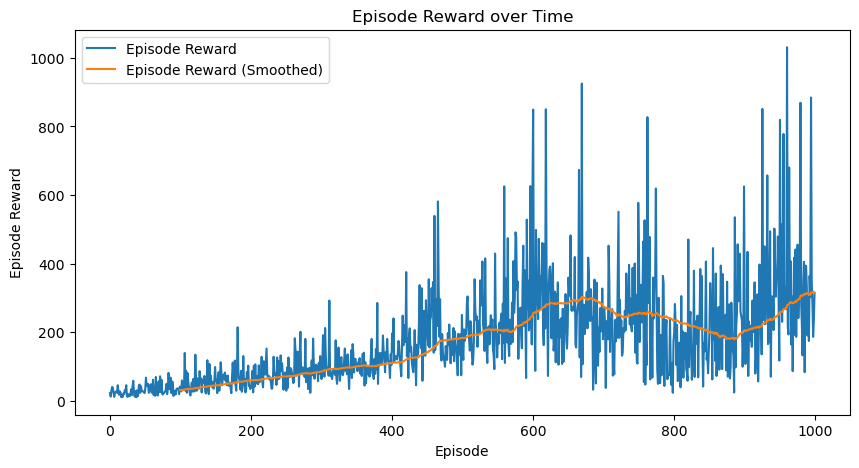

In [18]:
if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    Manger = TrainManager(env = env,
                        episode_num = 1000,
                        lr = 0.001,
                        gamma = 0.98
                        )
    Manger.train()
    Manger.plotting()